# Trabajo Práctico: 4 Análisis de Datos 

In [1]:
# Importar
import os, re
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import spacy
from wordcloud import WordCloud

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Descargas NLTK necesarias (ejecutar si no están)
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)

# Cargar spaCy
nlp = spacy.load("en_core_web_sm")

# Crear salida
OUT = Path("output_tp4_custom")
OUT.mkdir(exist_ok=True)

In [3]:
# Ruta 
ruta_user = Path(r"C:\Documentos\SEXTO SEMESTRE\Ciencia de Datos")
file1 = ruta_user / "text1.txt"
file2 = ruta_user / "text2.txt"

In [5]:
# fallback a /mnt/data si no existe en tu PC
if not file1.exists() or not file2.exists():
    file1 = Path("/mnt/data/text1.txt")
    file2 = Path("/mnt/data/text2.txt")

if not file1.exists() or not file2.exists():
    raise FileNotFoundError("No encontré text1.txt/text2.txt en la ruta indicada ni en /mnt/data. Ajusta ubicación.")

with open(file1, "r", encoding="utf-8", errors="ignore") as f:
    raw1 = f.read()
with open(file2, "r", encoding="utf-8", errors="ignore") as f:
    raw2 = f.read()

(OUT / "text1_raw.txt").write_text(raw1, encoding="utf-8")
(OUT / "text2_raw.txt").write_text(raw2, encoding="utf-8")
print("Archivos cargados:", file1, file2)


Archivos cargados: C:\Documentos\SEXTO SEMESTRE\Ciencia de Datos\text1.txt C:\Documentos\SEXTO SEMESTRE\Ciencia de Datos\text2.txt


In [6]:
# Normalización (eliminar HTML, URLs, puntuación, emojis, guiones y espacios extra)
def normalize_text(text):
    text = text.replace("\r\n", "\n")
    text = re.sub(r"<.*?>", " ", text)                     # HTML tags
    text = re.sub(r"http\S+|www\.\S+", " ", text)          # URLs
    # quitar menciones/hashtags (si hubiera)
    text = re.sub(r"@\w+|#\w+", " ", text)
    # reemplazar guiones largos y guiones por espacio
    text = text.replace("—", " ").replace("–", " ").replace("-", " ")
    # mantener letras (incluye tildes y ñ), números y saltos de línea; convertir otros símbolos a espacio
    text = re.sub(r"[^A-Za-z0-9áéíóúÁÉÍÓÚñÑüÜ\s\n]", " ", text)
    # normalizar espacios
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n\s+", "\n", text)
    text = re.sub(r"\s+\n", "\n", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()
text1_clean = normalize_text(raw1)
text2_clean = normalize_text(raw2)

(OUT / "text1_clean.txt").write_text(text1_clean, encoding="utf-8")
(OUT / "text2_clean.txt").write_text(text2_clean, encoding="utf-8")

# Mostrar fragmentos para comprobar
print("\n--- Fragmento text1 limpio ---\n")
print(text1_clean[:800])
print("\n--- Fragmento text2 limpio ---\n")
print(text2_clean[:800])


--- Fragmento text1 limpio ---

pág 1503
IMPACTO DE LAS TECNOLOGÍAS DE
ENERGÍA RENOVABLE EN LA MITIGACIÓN
DEL CAMBIO CLIMÁTICO UNA REVISIÓN
DE LITERATURA DE LOS ÚLTIMOS 5 AÑOS
IMPACT OF RENEWABLE ENERGY TECHNOLOGIES ON
CLIMATE CHANGE MITIGATION A LITERATURE REVIEW
OF THE LAST 5 YEARS
Bismarck Nicolay Jiménez Cazar
Universidad Técnica Estatal de Quevedo
Jessica Alexandra Gomez Moyano
Universal Técnica Estatal de Quevedo
Johanna Lilibeth Ramírez Ruiz
Universal Técnica Estatal de Quevedo
Jonathan Alfredo Vera García
Universal Técnica Estatal de Quevedo
pág 1504 DOI
Impacto de las tecnologías de energía renovable en la mitigación del cambio
climático una revisión de literatura de los últimos 5 Años
Bismarck Nicolay Jiménez Cazar1
solrobi1 com
0003 3470 1414
Universidad Técnica Estatal de Quevedo
Jessica Alexandra Gomez Moyan

--- Fragmento text2 limpio ---

Latin American Journal of Trade Policy 7 2020 ISSN 079 9668 Universidad de Chile
6 Análisis de la Posición Comercial de China y Estad

In [7]:
# DESCRIPCIÓN y comparación SIN spaCy (párrafos, frases, palabras) 
def describe_no_spacy(text):
    paragraphs = [p for p in re.split(r'\n{1,}', text) if p.strip()]
    # usar nltk.sent_tokenize para frases
    sentences = nltk.tokenize.sent_tokenize(text)
    words = re.findall(r"\b\w+\b", text)
    return {"paragraphs": len(paragraphs), "sentences": len(sentences), "words": len(words),
            "avg_words_per_sentence": round(len(words)/max(1,len(sentences)),2)}

desc1 = describe_no_spacy(text1_clean)
desc2 = describe_no_spacy(text2_clean)
df_desc = pd.DataFrame([desc1, desc2], index=["Text1","Text2"])
df_desc.to_csv(OUT / "basic_description.csv")
print("\nDescripción básica (sin spaCy):\n", df_desc)


Descripción básica (sin spaCy):
        paragraphs  sentences  words  avg_words_per_sentence
Text1         524          1   5804                  5804.0
Text2         598          1   5883                  5883.0


In [8]:
# Reflexión breve automática sobre longitud y complejidad
def short_reflection(d1, d2):
    s = []
    for name, d in (("Text1",d1),("Text2",d2)):
        s.append(f"{name}: {d['words']} palabras, {d['sentences']} oraciones, longitud media oración={d['avg_words_per_sentence']}")
    longer = "Text1" if d1['words']>d2['words'] else "Text2" if d2['words']>d1['words'] else "mismo tamaño"
    s.append(f"Comparación: el texto más largo es {longer}.")
    return "\n".join(s)

reflex = short_reflection(desc1, desc2)
(OUT / "basic_reflection.txt").write_text(reflex, encoding="utf-8")
print("\nReflexión:\n", reflex)



Reflexión:
 Text1: 5804 palabras, 1 oraciones, longitud media oración=5804.0
Text2: 5883 palabras, 1 oraciones, longitud media oración=5883.0
Comparación: el texto más largo es Text2.


In [9]:
# spaCy: Tokenización, remoción stopwords y lematización
def spacy_tokens_lemmas(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return tokens, doc

tokens1, doc1 = spacy_tokens_lemmas(text1_clean)
tokens2, doc2 = spacy_tokens_lemmas(text2_clean)

pd.DataFrame(Counter(tokens1).most_common(200), columns=["token","count"]).to_csv(OUT / "text1_tokens_freq.csv", index=False)
pd.DataFrame(Counter(tokens2).most_common(200), columns=["token","count"]).to_csv(OUT / "text2_tokens_freq.csv", index=False)
print("\nTokenización y lematización completadas.")



Tokenización y lematización completadas.


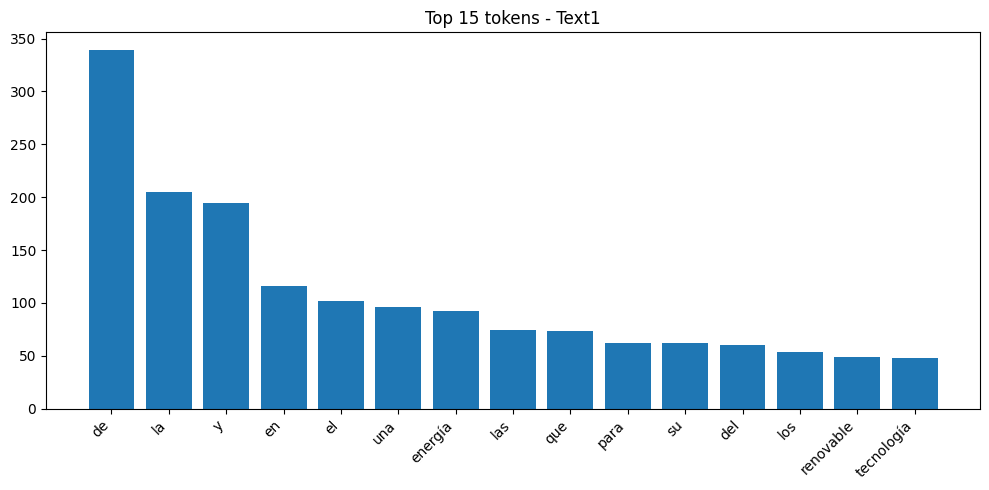

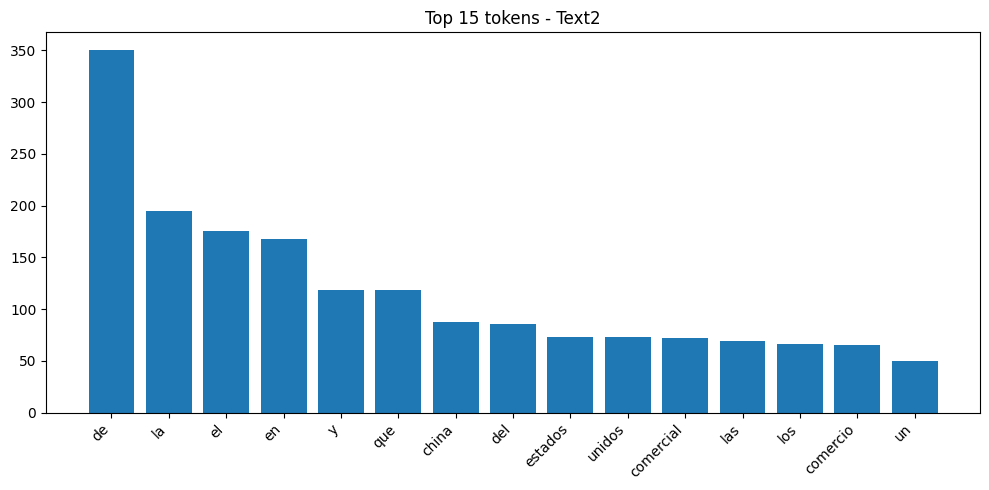

In [10]:
#Palabras más frecuentes y gráficas
def plot_top(counter, title, fname, n=15):
    top = counter.most_common(n)
    if not top: 
        print("No hay tokens para", title); return
    words, counts = zip(*top)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(OUT / f"{fname}.png", dpi=150)
    plt.show()

freq1 = Counter(tokens1)
freq2 = Counter(tokens2)
plot_top(freq1, "Top 15 tokens - Text1", "text1_top15")
plot_top(freq2, "Top 15 tokens - Text2", "text2_top15")

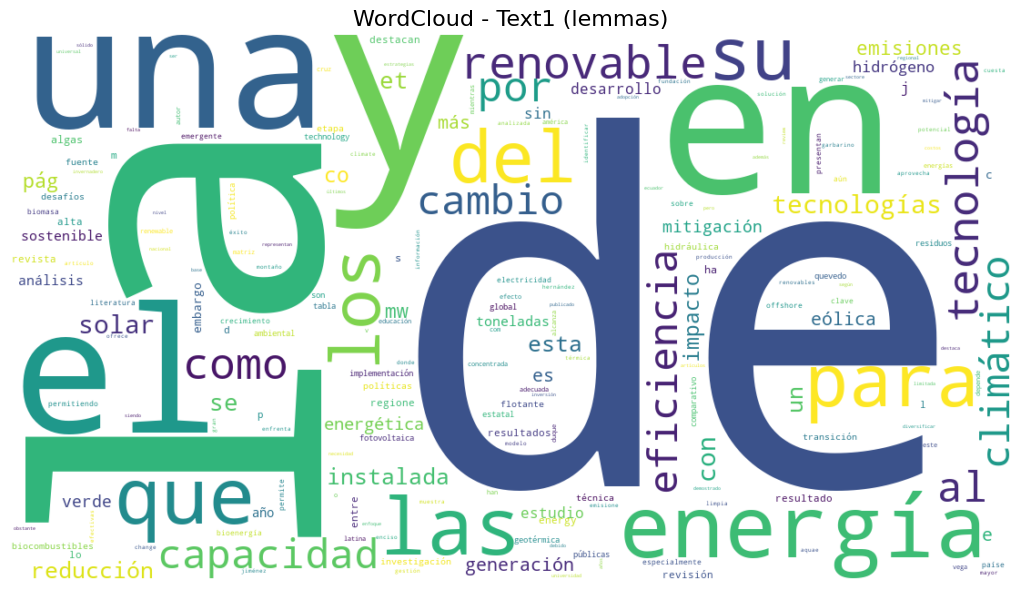

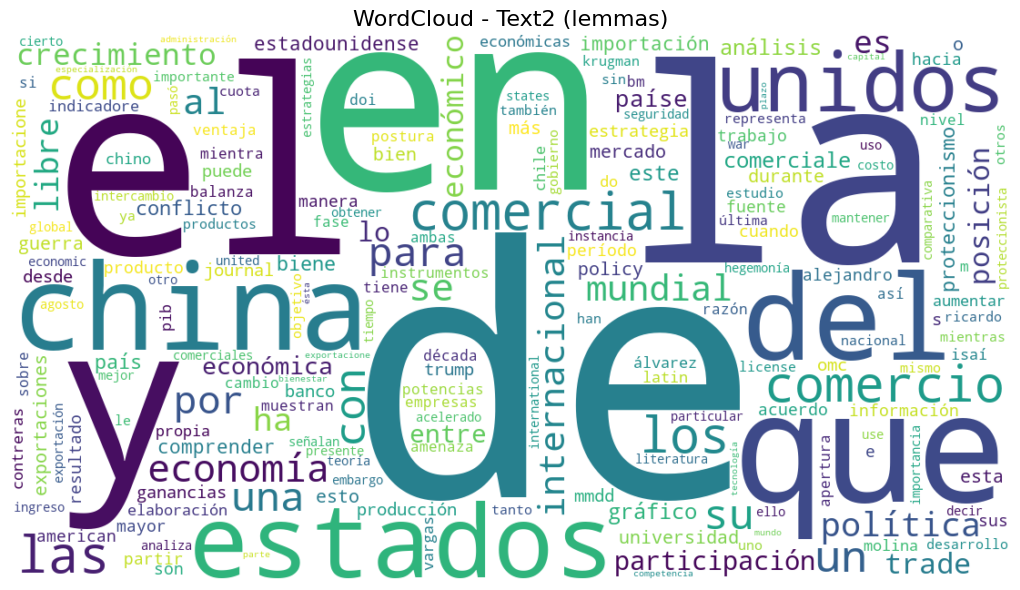

In [11]:
# Nubes de palabras generales (lemmas sin stopwords)
def wordcloud_from_freq(counter, title, fname):
    wc = WordCloud(width=1100, height=600, background_color='white').generate_from_frequencies(dict(counter))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(OUT / f"{fname}.png", dpi=150)
    plt.show()

wordcloud_from_freq(freq1, "WordCloud - Text1 (lemmas)", "wc_text1_general")
wordcloud_from_freq(freq2, "WordCloud - Text2 (lemmas)", "wc_text2_general")

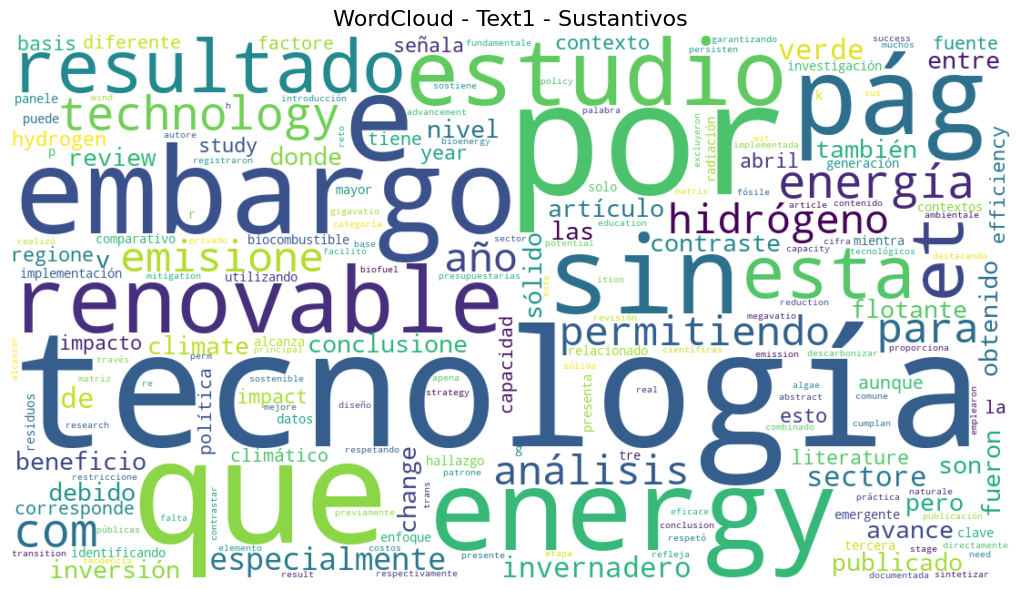

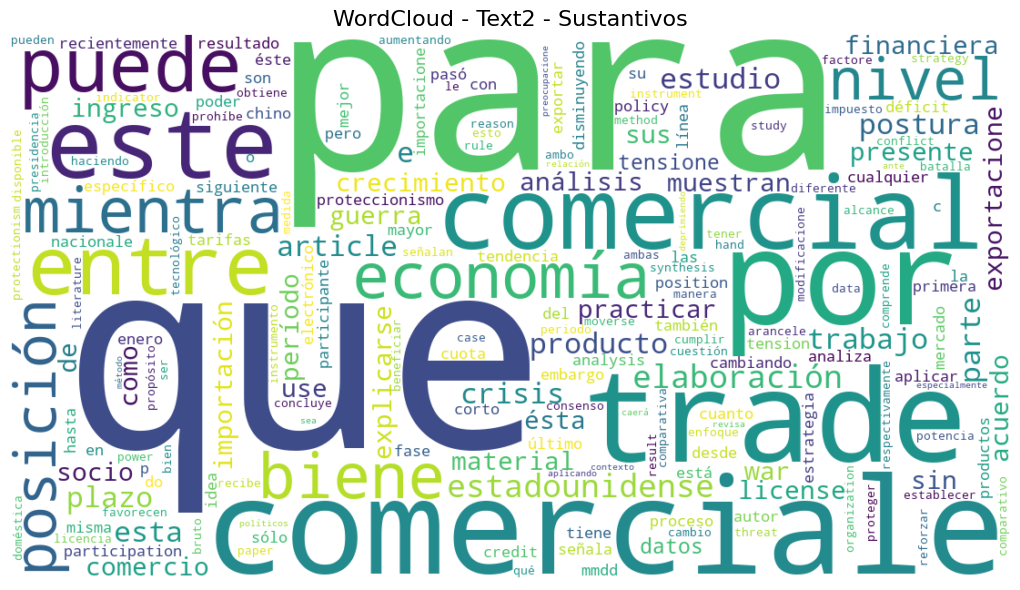

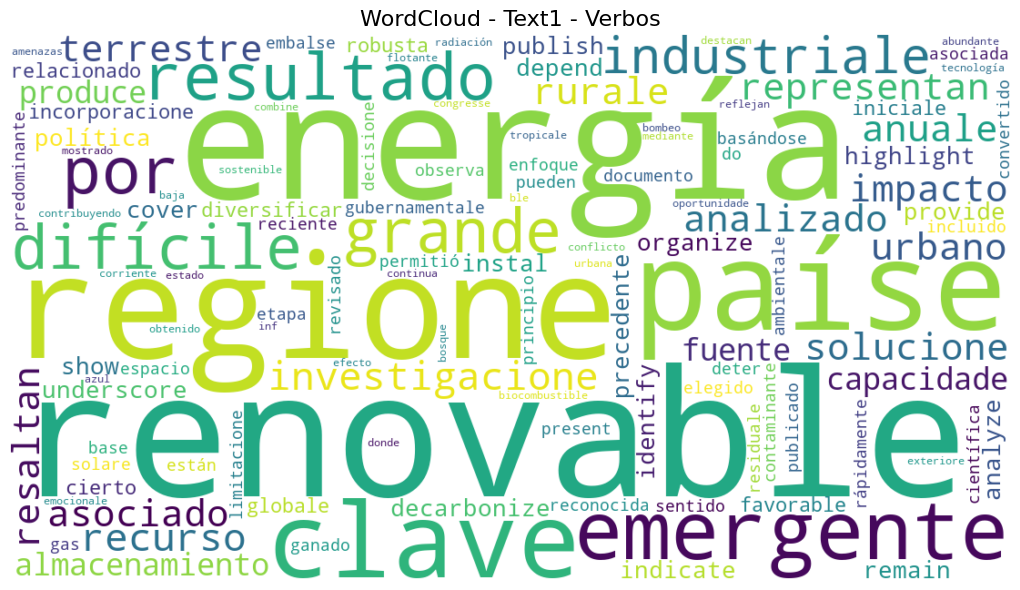

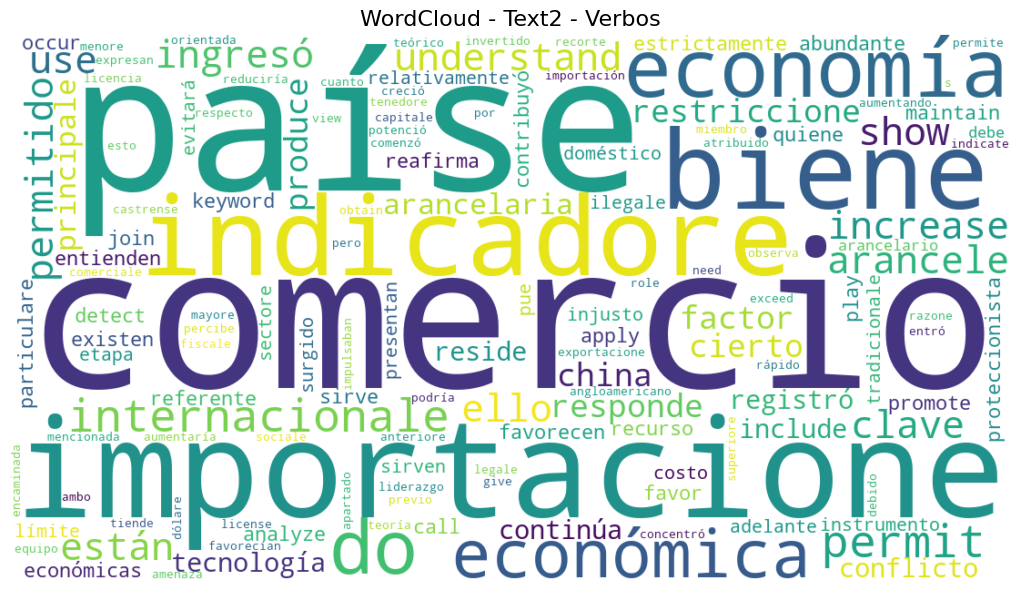

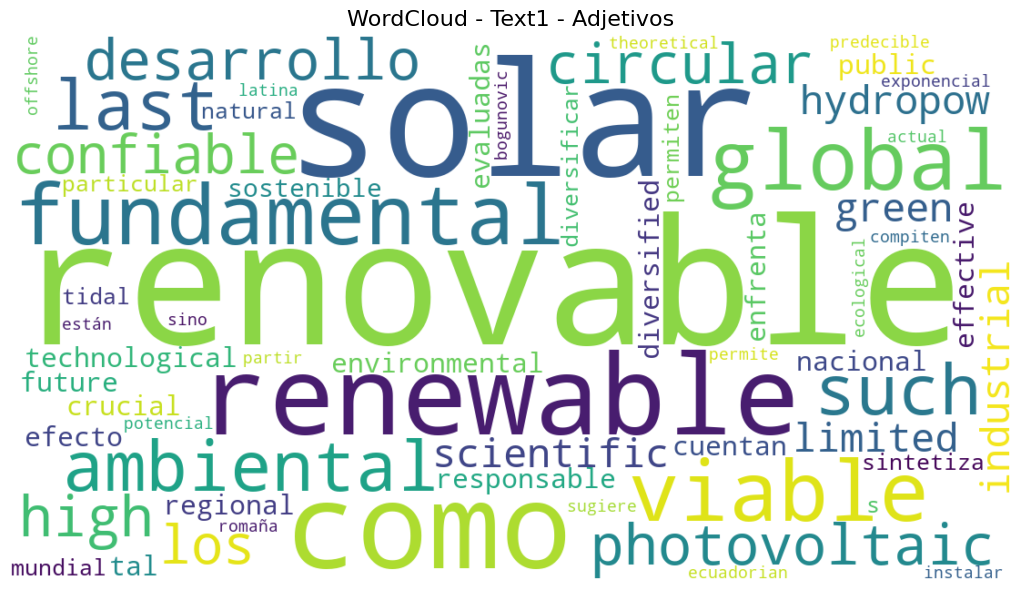

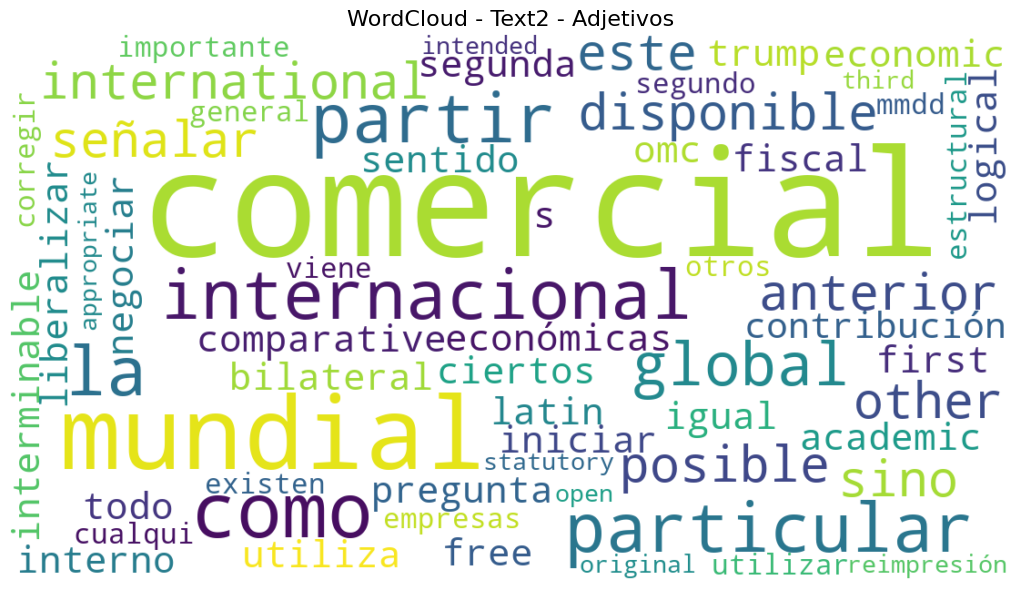

In [12]:
# POS tagging: sustantivos, verbos y adjetivos + nubes por categoría
def freq_by_pos(doc, pos_tag):
    return Counter([token.lemma_.lower() for token in doc if token.pos_ == pos_tag and token.is_alpha])

pos_list = [("NOUN","Sustantivos"), ("VERB","Verbos"), ("ADJ","Adjetivos")]
for tag, name in pos_list:
    c1 = freq_by_pos(doc1, tag)
    c2 = freq_by_pos(doc2, tag)
    # guardar csv top50
    pd.DataFrame(c1.most_common(50), columns=["token","count"]).to_csv(OUT / f"text1_{tag.lower()}_top50.csv", index=False)
    pd.DataFrame(c2.most_common(50), columns=["token","count"]).to_csv(OUT / f"text2_{tag.lower()}_top50.csv", index=False)
    # nubes
    wordcloud_from_freq(c1, f"WordCloud - Text1 - {name}", f"wc_text1_{tag.lower()}")
    wordcloud_from_freq(c2, f"WordCloud - Text2 - {name}", f"wc_text2_{tag.lower()}")

In [13]:
# Extraer tripletas SVO
def extract_svo(doc, max_examples=300):
    svos = []
    for sent in doc.sents:
        root = sent.root
        if root.pos_ == "VERB":
            subjects = [tok for tok in root.lefts if tok.dep_ in ("nsubj","nsubjpass")]
            objects = [tok for tok in root.rights if tok.dep_ in ("dobj","obj","pobj")]
            for s in subjects:
                for o in objects:
                    svos.append((s.text, root.lemma_, o.text))
    return svos[:max_examples]

svo1 = extract_svo(doc1)
svo2 = extract_svo(doc2)
pd.DataFrame(svo1, columns=["subject","verb","object"]).to_csv(OUT / "svo_text1.csv", index=False)
pd.DataFrame(svo2, columns=["subject","verb","object"]).to_csv(OUT / "svo_text2.csv", index=False)
print("\nEjemplos SVO Text1 (primeros 10):", svo1[:10])
print("Ejemplos SVO Text2 (primeros 10):", svo2[:10])



Ejemplos SVO Text1 (primeros 10): [('mayor', 'industriale', 'embargo'), ('efficiency', 'indicate', 'relevancia'), ('conclusions', 'indicate', 'relevancia'), ('nuevas', 'incorporacione', 'embargo'), ('energías', 'paíse', 'como'), ('energías', 'paíse', 'gracias'), ('energías', 'paíse', 'favorables'), ('capacidad', 'representan', 'apenas'), ('capacidad', 'representan', 'evidencia'), ('documentadas', 'renovable', 'especial')]
Ejemplos SVO Text2 (primeros 10): [('O57', 'analyze', 'position'), ('O57', 'analyze', 'analysis'), ('O57', 'analyze', 'Keywords'), ('paper', 'analyze', 'position'), ('paper', 'analyze', 'analysis'), ('paper', 'analyze', 'Keywords'), ('potencias', 'económica', 'progresiva'), ('potencias', 'económica', 'mundial'), ('Unidos', 'reafirma', 'productos'), ('Unidos', 'reafirma', 'operar')]


In [14]:
# Bigrams y Trigrams
def top_ngrams(text, ngram_range=(2,2), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit([text])
    bag = vec.transform([text])
    sum_words = bag.sum(axis=0)
    words_freq = [(w, int(sum_words[0, idx])) for w, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

bigrams1 = top_ngrams(text1_clean, (2,2), 30)
trigrams1 = top_ngrams(text1_clean, (3,3), 30)
bigrams2 = top_ngrams(text2_clean, (2,2), 30)
trigrams2 = top_ngrams(text2_clean, (3,3), 30)

pd.DataFrame(bigrams1, columns=["ngram","count"]).to_csv(OUT / "text1_bigrams.csv", index=False)
pd.DataFrame(trigrams1, columns=["ngram","count"]).to_csv(OUT / "text1_trigrams.csv", index=False)
pd.DataFrame(bigrams2, columns=["ngram","count"]).to_csv(OUT / "text2_bigrams.csv", index=False)
pd.DataFrame(trigrams2, columns=["ngram","count"]).to_csv(OUT / "text2_trigrams.csv", index=False)


In [15]:
# Análisis de sentimiento (VADER) por oración y resumen
sia = SentimentIntensityAnalyzer()

def sentiment_sentence_df(text):
    sents = nltk.tokenize.sent_tokenize(text)
    records = []
    for s in sents:
        s_strip = s.strip()
        if not s_strip:
            continue
        scores = sia.polarity_scores(s_strip)
        scores['sentence'] = s_strip
        records.append(scores)
    return pd.DataFrame(records)

sent_df1 = sentiment_sentence_df(text1_clean)
sent_df2 = sentiment_sentence_df(text2_clean)

In [16]:
# resumen estadístico
summary_sent = pd.DataFrame({
    "text":["Text1","Text2"],
    "mean_compound":[sent_df1['compound'].mean() if not sent_df1.empty else 0,
                     sent_df2['compound'].mean() if not sent_df2.empty else 0],
    "median_compound":[sent_df1['compound'].median() if not sent_df1.empty else 0,
                       sent_df2['compound'].median() if not sent_df2.empty else 0]
})
summary_sent.to_csv(OUT / "sentiment_summary.csv", index=False)
print("\nSentiment summary:\n", summary_sent)


Sentiment summary:
     text  mean_compound  median_compound
0  Text1        -0.9804          -0.9804
1  Text2         0.9892           0.9892


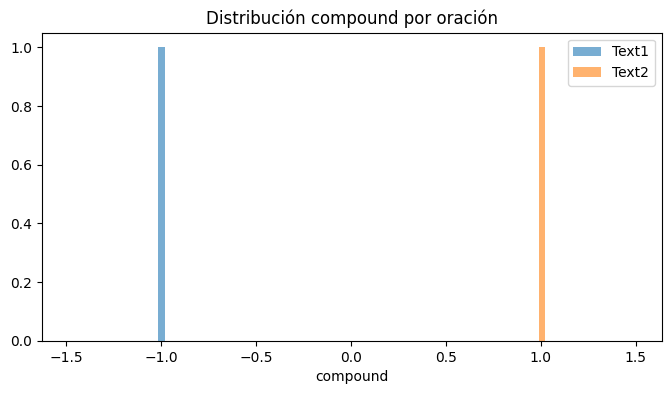

In [17]:
# histograma compound
plt.figure(figsize=(8,4))
plt.hist(sent_df1['compound'].dropna(), bins=30, alpha=0.6, label='Text1')
plt.hist(sent_df2['compound'].dropna(), bins=30, alpha=0.6, label='Text2')
plt.legend()
plt.title("Distribución compound por oración")
plt.xlabel("compound")
plt.savefig(OUT / "sentiment_compound_hist.png", dpi=150)
plt.show()

In [18]:
# Guardar tablas y resultados clave
pd.DataFrame(freq1.most_common(50), columns=["token","count"]).to_csv(OUT / "text1_top50_tokens.csv", index=False)
pd.DataFrame(freq2.most_common(50), columns=["token","count"]).to_csv(OUT / "text2_top50_tokens.csv", index=False)